In [1]:
# preamble
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run lib/preamble.py

Using TensorFlow backend.


# Models

In [2]:
!cat lib/models.py

import clgen
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import sys
import time

from clgen import clutil
from clgen.atomizer import CharacterAtomizer, GreedyAtomizer

from collections import defaultdict, Counter

from keras.layers import Input, Dropout, Embedding, merge, LSTM, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.visualize_util import model_to_dot
from keras.wrappers.scikit_learn import KerasClassifier

from scipy.stats import percentileofscore
from scipy.stats.mstats import gmean
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier


def cgo13():
    def create_model(seed=None, **kwargs)

### Model description

In [3]:
%run lib/models.py
d = load_data_desc("amd", source="B", max_seq_len=1024, atomizer=CharacterAtomizer)
m = harry()["create_model"](data_desc=d)

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 84
pad val 84
padded seq length 1024


In [4]:
m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
code_in (InputLayer)             (None, 1024)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1024, 64)      5376        code_in[0][0]                    
____________________________________________________________________________________________________
data_in (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 16)            5184        embedding_1[0][0]                
___________________________________________________________________________________________

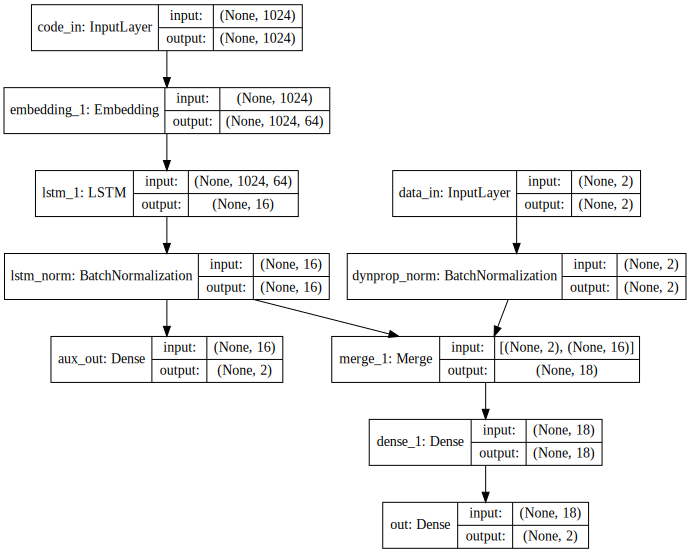

In [5]:
SVG(model_to_dot(m, show_shapes=True).create(prog='dot', format='svg'))

# Evaluate

In [67]:
from itertools import product

def source2str(s):
    if s == "B":
        return "Benchmarks"
    elif s == "S":
        return "CLgen"
    elif s == "BS":
        return "w. CLgen"
    else:
        raise Exception
        
def platform2str(p):
    if p == "amd":
        return "AMD Tahiti 7970"
    elif p == "nvidia":
        return "NVIDIA GTX 970"
    else:
        raise Exception
        
def model2str(m):
    if m == "zero_r":
        return "Static mapping"
    elif m == "cgo13":
        return "CGO'13"
    elif m == "bruno":
        return "DeepTune"
    else:
        return m.title()

### Load Data

In [68]:
%run lib/preamble.py
%run lib/models.py

models = ["zero_r", "cgo13", "karl", "sally", "barry", "turner", "fred", "bruno" ]
platforms = ["amd", "nvidia"]
sources = ["B"]#, "BS"]
atomizers = ["GreedyAtomizer"]#, "CharacterAtomizer"]
n_splits = 10
splits = range(n_splits)
seed = 204

data = None

for model, platform, source, atomizer, split_i in product(models, platforms, sources, atomizers, splits):
    result = load_result(globals().get(model)(), platform, source, 
                         atomizer=atomizer, maxlen=1024, seed=seed,
                         n_splits=n_splits, split_i=split_i)
    if not result:
        continue
    
    frame = result["dataframe"]
    frame["correct"] = result["correct"]
    frame["acc"] = result["correct"] * 100
    frame["p_speedup"] = result["speedups"]
    frame["p_speedup_perc"] = frame["p_speedup"] * 100
    frame["model"] = [model] * len(frame)
    frame["platform"] = [platform] * len(frame)
    frame["atomizer"] = [atomizer] * len(frame)
    frame["model_name"] = model2str(model)

    if data is None:
        data = frame
    else:
        data = pd.concat((data, frame))
        
model_names = sorted(set(data["model_name"]))
suite_names = sorted(set(data["source"]))
benchmark_names = sorted(set(data["benchmark_name"]))

d = data.copy()

# Append aggregate "Average" rows:
for platform, atomizer in product(platforms, atomizers):
    # TODO: source B, BS
    msk = (data["platform"] == platform) & (data["atomizer"] == atomizer)
    r = data[msk].groupby('model_name').mean()
    r["source"] = ["Average"] * len(r)
    r["platform"] = [platform] * len(r)
    r["atomizer"] = [atomizer] * len(r)
    r["model_name"] = model_names
    d = d.append(r)

assert(len(d[d["source"] == "Average"]) == len(list(product(platforms, sources, atomizers))) * len(model_names))
data

,benchmark,dataset,comp,rational,mem,localmem,coalesced,atomic,transfer,wgsize,...,seq_len,seq,correct,acc,p_speedup,p_speedup_perc,model,platform,atomizer,model_name
9,amd-app-sdk-3.0-ScanLargeArrays-ScanLargeArrays,default,32,3,21,14,4,0,263168,128,...,513,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,0.505803,50.580324,zero_r,amd,GreedyAtomizer,Static mapping
11,amd-app-sdk-3.0-ScanLargeArrays-prefixSum,default,31,3,19,13,3,0,263168,64,...,486,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,0.701699,70.169912,zero_r,amd,GreedyAtomizer,Static mapping
25,npb-3.3-BT-compute_rhs2,B,27,4,2,0,2,0,1313675032,32,...,375,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",False,0,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping
26,npb-3.3-BT-compute_rhs2,S,27,4,2,0,2,0,1807992,60,...,375,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,0.790205,79.020479,zero_r,amd,GreedyAtomizer,Static mapping
27,npb-3.3-BT-compute_rhs2,W,27,4,2,0,2,0,15948384,48,...,375,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping
36,npb-3.3-BT-compute_rhs5,A,1260,23,8,0,87,0,320457304,62,...,14289,"[1, 113, 51, 18, 52, 8, 1, 10, 1, 7, 7, 7, 15,...",False,0,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping
42,npb-3.3-BT-compute_rhs6,S,16,4,1,0,2,0,1807992,60,...,308,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping
55,npb-3.3-BT-exact_rhs2,W,340,26,5,0,112,0,15948384,44,...,4072,"[8, 8, 1, 9, 1, 7, 20, 13, 15, 1, 9, 1, 123, 5...",True,100,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping
69,npb-3.3-BT-initialize1,B,12,4,1,0,1,0,1313675032,32,...,273,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",False,0,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping
74,npb-3.3-BT-initialize2,S,116,10,7,0,40,0,1807992,60,...,789,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping


In [69]:
# print model accuracy and speedup (per-platform)
amd_msk = (data["platform"] == "amd") & (data["atomizer"] == "GreedyAtomizer")
nvidia_msk = (data["platform"] == "nvidia") & (data["atomizer"] == "GreedyAtomizer")

def table(D, sortby='acc'):
    print(D[["model_name", "source", "acc", "p_speedup"]].groupby(
        "model_name").mean().sort_values(sortby, ascending=False))
    
table(data)
print("\nAMD:")
table(data[amd_msk])
print("\nNVIDIA:")
table(data[nvidia_msk])

                      acc  p_speedup
model_name                          
DeepTune        83.823529   0.723524
Karl            82.205882   0.726738
Fred            82.018349   0.724780
Turner          81.470588   0.729473
Barry           81.397059   0.728680
Sally           81.397059   0.729643
CGO'13          73.161765   0.734061
Static mapping  57.867647   0.788421

AMD:
                      acc  p_speedup
model_name                          
DeepTune        86.029412   0.705724
Karl            85.735294   0.704323
Barry           84.117647   0.722663
Fred            83.639706   0.707930
Sally           83.382353   0.721539
Turner          82.647059   0.713623
CGO'13          73.382353   0.705625
Static mapping  58.823529   0.764933

NVIDIA:
                      acc  p_speedup
model_name                          
DeepTune        81.617647   0.741324
Fred            80.402930   0.741568
Turner          80.294118   0.745323
Sally           79.411765   0.737747
Barry           78.6764

In [70]:
order = ["AMD", "NPB", "NVIDIA", "Parboil", "Polybench", "Rodinia", "SHOC", "Average"]

def plot_ex1_graph(x="source", y="acc", hue="model_name", order=order, n_palette=len(model_names),
                   data=data, atomizer="CharacterAtomizer", ylabel="Accuracy (%)", ci=None,
                   ylim=(0, 100), yaxis_fmt="%d%%"):
    palette = sns.cubehelix_palette(n_palette, rot=1.8, light=.85, dark=.35)

    for i, platform in enumerate(["amd", "nvidia"]):
        plt.subplot(1, 2, i + 1)
        msk = (data["platform"] == platform) & (data["atomizer"] == atomizer)
        ax = sns.barplot(x=x, y=y, hue=hue, order=order, palette=palette,
                         data=data[msk],
                         ci=ci, errwidth=1, capsize=.08)

        plt.ylim(ylim)
        plt.xlabel("")
        
        # vertical divider for "Average" column
        plt.axvline(x=plt.xlim()[1] - 1, color="k", lw=1, linestyle="--")
        
        if not i:
            # first plot
            plt.ylabel(ylabel)
            ax.legend().set_visible(False)
        else:     
            # second plot
            plt.ylabel("")
            plt.legend(loc='upper left', bbox_to_anchor=(1,1))
            ax.get_legend().set_title("")  # no legend title
            ax.get_legend().draw_frame(True)
            
        from matplotlib.ticker import FormatStrFormatter
        if yaxis_fmt:
            plt.gca().yaxis.set_major_formatter(FormatStrFormatter(yaxis_fmt))
        
        plt.title(platform2str(platform))

    viz.finalise(figsize=(9,2.6))

Atomizer: GreedyAtomizer


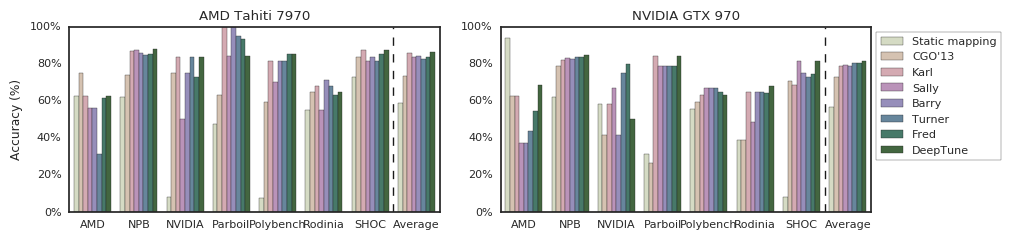

Atomizer: GreedyAtomizer


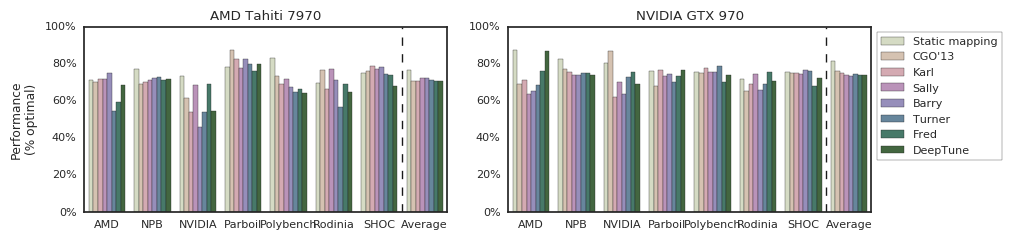

In [71]:
for atomizer in atomizers:
    print("Atomizer:", atomizer)
    plot_ex1_graph(x="source", order=suite_names + ["Average"], y="acc", data=d, atomizer=atomizer)
    
for atomizer in atomizers:
    print("Atomizer:", atomizer)
    plot_ex1_graph(x="source", order=suite_names + ["Average"], y="p_speedup_perc", 
                   data=d, atomizer=atomizer, ylabel="Performance\n(% optimal)")

### Accuracy

Atomizer: GreedyAtomizer


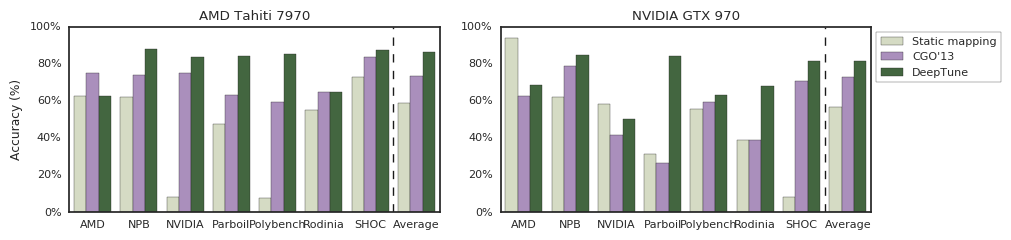

In [72]:
_d = d[(d["model_name"] == "Static mapping") | (d["model_name"] == "CGO'13") | (d["model_name"] == "DeepTune")]
for atomizer in atomizers:
    print("Atomizer:", atomizer)
    plot_ex1_graph(x="source", order=suite_names + ["Average"], y="acc", data=_d, n_palette=3, atomizer=atomizer)

### Performance (% optimal)

Atomizer: GreedyAtomizer


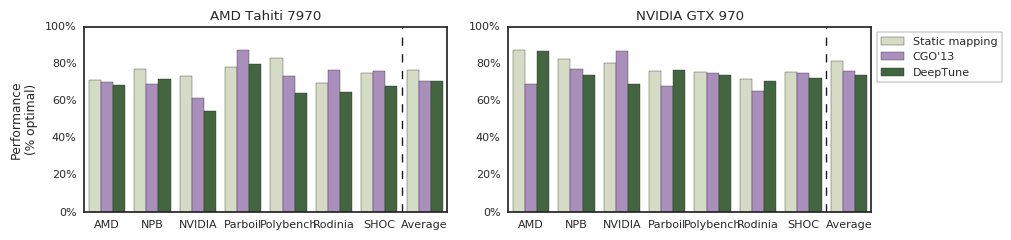

In [73]:
for atomizer in atomizers:
    print("Atomizer:", atomizer)
    plot_ex1_graph(x="source", order=suite_names + ["Average"], y="p_speedup_perc", 
                   data=_d, n_palette=3, atomizer=atomizer, ylabel="Performance\n(% optimal)")